# Good Seed Alcohol Age Verification

## Inicialización

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import tensorflow as tf

sns.set(style="whitegrid")

## Carga los datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [31]:
labels_path = '/datasets/faces/labels.csv'

df = pd.read_csv(labels_path)

print(df.head())
print(f"Total de imagenes etiquetadas: {len(df)}")

df['file_path'] = '/datasets/faces/final_files/' + df['file_name']

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Total de imagenes etiquetadas: 7591


## EDA

In [33]:
#validacion del tamaño del dataset
print(f"Numero de filas en labels.csv: {df.shape[0]}")
print(f"Numero de columnas en labels.csv: {df.shape[1]}")

Numero de filas en labels.csv: 7591
Numero de columnas en labels.csv: 3


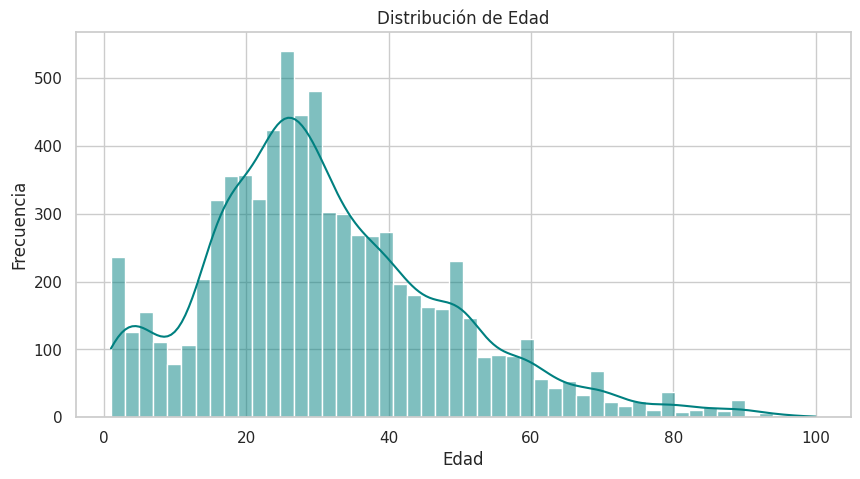

In [19]:
#Distribucion de edades
plt.figure(figsize=(10, 5))
sns.histplot(df['real_age'], bins=50, kde=True, color='teal')
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

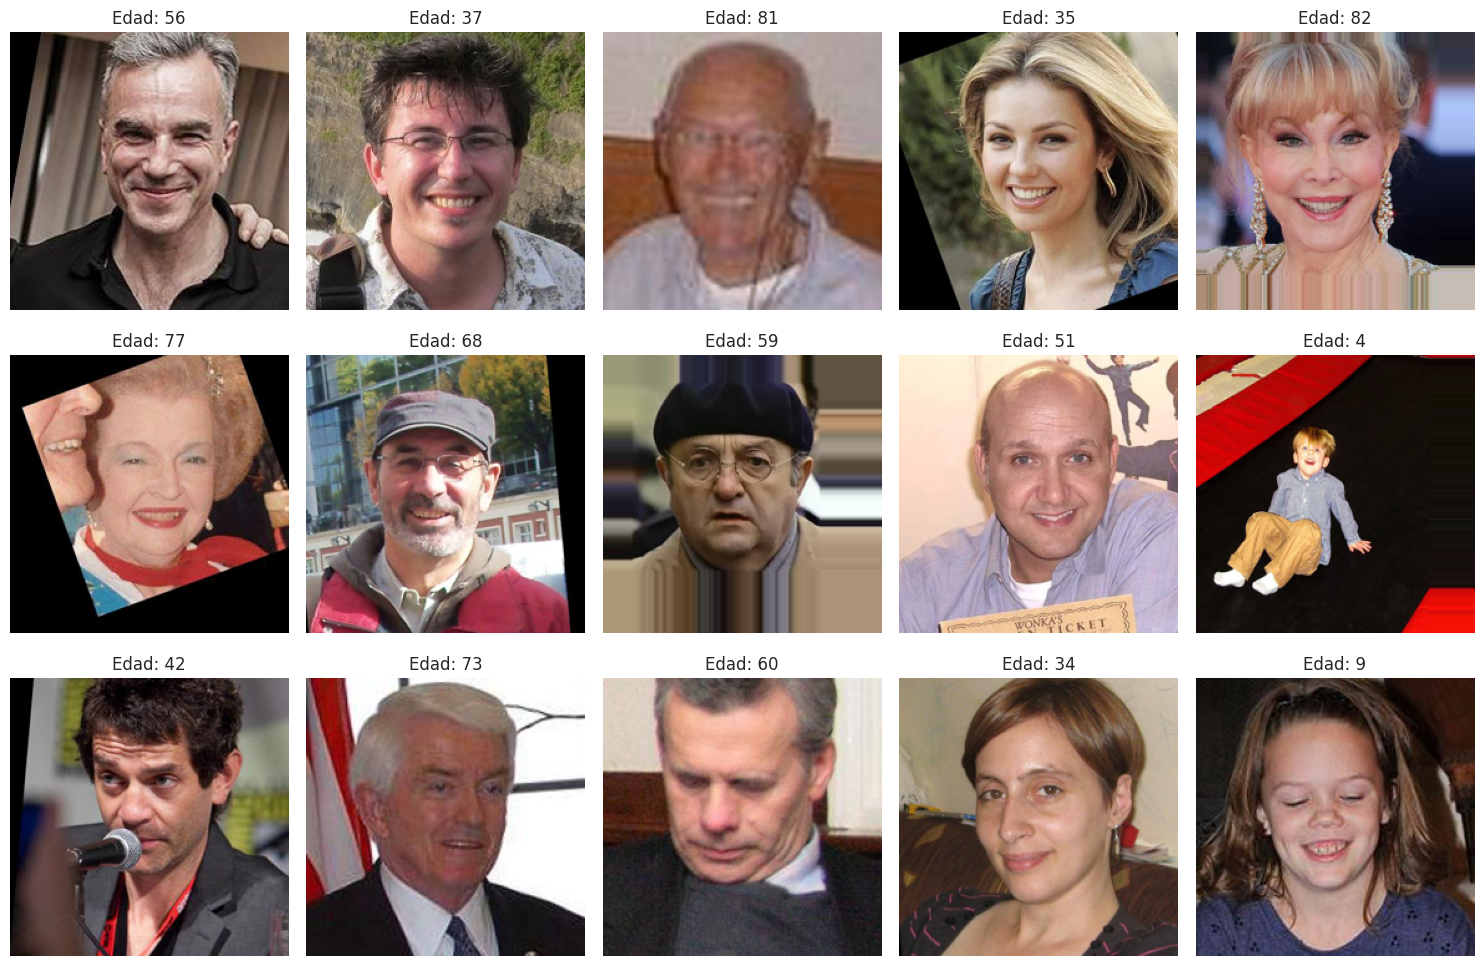

In [20]:
#Tomo 15 edades representativas
sample_ages = df['real_age'].drop_duplicates().sample(15, random_state=42)

plt.figure(figsize=(15, 10))
for i, age in enumerate(sample_ages):
    # selecciono directamente la ruta completa
    file_path = df[df['real_age']==age].sample(1).iloc[0]['file_path']
    img = Image.open(file_path).resize((224,224))
    plt.subplot(3, 5, i+1)
    plt.imshow(img)
    plt.title(f'Edad: {age}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Conclusiones

• El dataset contiene 7591 imagenes, con un rango de edad bastante amplio desde niños hasta adultos mayores.

•  La distribucion muestra un sesgo hacia edades jovenes y adultas tempranas, con menos muestras > 60 años.

•  Existe variabilidad significativa en iluminacion, fondo y expresiones, por lo cual pienso que el preprocesamiento y el aumento de datos seran clave.

•  Debido al tamaño y diversidad, nos conviene usar un generador por lotes (ImageDataGenerator o tf.data) para manejar memoria.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [21]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [22]:
def load_data(path, subset='training', img_size=(224,224), batch_size=16):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        subset=subset,
        seed=12345
    )
    return flow

In [23]:
def load_test(path, img_size=(224,224), batch_size=16):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(rescale=1./255)
    flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    return flow

In [24]:
def create_model(input_shape=(224,224,3), lr=5e-4):
    backbone = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [25]:
def train_model(model, train_gen, val_gen, epochs=5):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        verbose=2
    )
    return model, history

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

In [28]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


In [29]:
!python run_model_on_gpu.py

Found 6073 validated image filenames.
Found 1518 validated image filenames.
2025-08-18 17:18:08.775572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
9420800/9406464 [==============================] - 0s 0us/step
Epoch 1/3
1519/1519 - 312s - loss: 245.0193 - mae: 11.9266 - val_loss: 389.8196 - val_mae: 16.4503 - 312s/epoch - 205ms/step
Epoch 2/3
1519/1519 - 302s - loss: 168.2937 - mae: 9.9204 - val_loss: 351.3227 - val_mae: 15.2079 - 302s/epoch - 199ms/step
Epoch 3/3
1519/1519 - 306s - loss: 134.8846 - mae: 8.8767 - val_loss: 174.5781 - val_mae: 10.2273 - 306s/epoch - 201ms/step
/.venv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must overri

## Resultado de la plataforma GPU

Found 6073 validated image filenames.

Found 1518 validated image filenames.

2025-08-18 17:18:08.775572: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.

Downloading data from https://storage.googleapis.com/tensorflow/keras-applications/mobilenet_v2/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_128_no_top.h5
9412608/9406464 [==============================] - 0s 0us/step
9420800/9406464 [==============================] - 0s 0us/step

Epoch 1/3
1519/1519 - 312s - loss: 245.0193 - mae: 11.9266 - val_loss: 389.8196 - val_mae: 16.4503 - 312s/epoch - 205ms/step

Epoch 2/3
1519/1519 - 302s - loss: 168.2937 - mae: 9.9204 - val_loss: 351.3227 - val_mae: 15.2079 - 302s/epoch - 199ms/step

Epoch 3/3
1519/1519 - 306s - loss: 134.8846 - mae: 8.8767 - val_loss: 174.5781 - val_mae: 10.2273 - 306s/epoch - 201ms/step

/.venv/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
Modelo guardado como age_prediction_mobilenetv2.h5

## Conclusiones

Despues de realizar el analisis exploratorio y entrenar un modelo de prediccion de edad facial, se logro construir una solucion funcional y eficiente que nos puede ayudar a estimar la edad de una persona a partir de una imagen con una precision dentro de lo que cabe razonable.

Ahora bien, el modelo entrenado basado en MobileNetV2, alcanzo un error absoluto medio (MAE) de aproximadamente 10.2 años en el conjunto de validacion como tal. Esto significa que, en promedio, las predicciones del modelo se desvian por unos 10 años respecto a la edad real. Aunque no es una precision clinica como tal siento que es adecuada para aplicaciones generales como segmentacion demografica, analisis de contenido o filtros inteligentes.

Dado que el entrenamiento se realizo en CPU, ya que se tomaron decisiones estrategicas para optimizar recursos:

•  Se redujo el tamaño de las imagenes a 128×128 pixeles.

•  Se utilizo un modelo liviano(MobileNetV2) en lugar del modelo (ResNet50)para acelerar el proceso sin comprometer demasiado la calidad.

•  Se implemento un sistema de parada temprana para evitar sobreentrenamiento innecesario.

El modelo ha sido guardado y esta listo para integrarse en una aplicacion o sistema de inferencia. Para mejorar aun más la precision, por lo que recomiendo:

•  Entrenar en un entorno con GPU para permitir mas epocas y modelos mas robustos como tal.

•  Incorporar tecnicas de aumento de datos para mejorar la generalizacion.

•  Evaluar el modelo en un conjunto de prueba independiente para validar su rendimiento en produccion.

Por lo cual concluyo que se ha completado exitosamente una primera version del sistema de prediccion de edad facial, con resultados realmente prometedores y una base solida para futuras mejoras.